# Setup

In [1]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

In [2]:
# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF

%pdb


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


In [3]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

In [4]:
dates = np.arange(
    np.datetime64('2006-02-09 00:00'), 
    np.datetime64('2006-02-14 00:10'),
    np.timedelta64(10, 'm'))

filenames, start_time, end_time = cf.CPOL_files_from_datetime_list(
    dates, base_dir=base_dir)

micro_physics = 'cpol'

tracks_obj  = tint.Tracks(params={
    'AMBIENT': 'ERA5', 'AMBIENT_BASE_DIR': ERA5_dir})

Gathering files.


In [8]:
micro_physics = 'lin'

dates = np.arange(
    np.datetime64('2006-02-08 12:00'), 
    np.datetime64('2006-02-13 10:10'),
    np.timedelta64(10, 'm'))

filenames, start_time, end_time = caf.caine_files_from_datetime_list(
    dates, micro_physics=micro_physics, 
    base_dir=WRF_dir)

tracks_obj  = tint.Tracks(params={
    'AMBIENT': 'WRF', 'AMBIENT_BASE_DIR': WRF_dir + 'lind02/'})

Gathering files.


In [4]:
micro_physics = 'thompson'

dates = np.arange(
    np.datetime64('2006-02-08 12:00'), 
    np.datetime64('2006-02-13 10:10'),
    np.timedelta64(10, 'm'))

filenames, start_time, end_time = caf.caine_files_from_datetime_list(
    dates, micro_physics=micro_physics, 
    base_dir=WRF_dir)

tracks_obj  = tint.Tracks(params={
    'AMBIENT': 'WRF', 'AMBIENT_BASE_DIR': WRF_dir + 'thompsond02/'})

Gathering files.


# Create Tracks

In [5]:
b_path = '/home/student.unimelb.edu.au/shorte1/Documents/'
b_path += 'CPOL_analysis/circ_b_ind_set.pkl'
with open(b_path, 'rb') as f:
    b_ind_set = pickle.load(f)

In [6]:
def gen_tracks(
        tracks_obj, filenames, rain=False, micro_physics='cpol', 
        save_dir=None, b_path=None, save_tracks=False):

    grids = (
        pyart.io.read_grid(fn, include_fields = ['reflectivity'])
        for fn in filenames)
    
    current_time = str(datetime.datetime.now())[0:-7]
    current_time = current_time.replace(" ", "_").replace(":", "_")
    current_time = current_time.replace("-", "")
        
    tracks_obj.get_tracks(grids, b_path=b_path)
    #tracks_obj = analysis.get_reanalysis_vars(tracks_obj)
    #tracks_obj = analysis.add_monsoon_regime(tracks_obj)

    if save_tracks and save_dir is not None:
        out_file_name = save_dir + 'tracks_obj_{}_{}.pkl'.format(
            micro_physics, current_time)
        with open(out_file_name, 'wb') as f:
            pickle.dump(tracks_obj, f)
        
    return tracks_obj

In [7]:
tracks_obj = gen_tracks(
    tracks_obj, filenames, micro_physics=micro_physics, 
    save_dir=save_dir, b_path=None, save_tracks=True)

/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/numba/core/consts.py:114: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return getattr(value, expr.attr)
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/numba/core/ir_utils.py:2097: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int

Getting ERA5 metadata.
Getting Intepolated ERA5 for next hour.
No objects found in scan 0.
No objects found in scan 1.
No objects found in scan 2.
No objects found in scan 3.
No objects found in scan 4.
No objects found in scan 5.
No objects found in scan 6.
No objects found in scan 7.
No objects found in scan 8.
No objects found in scan 9.
No objects found in scan 10.
No objects found in scan 11.
No objects found in scan 12.
No objects found in scan 13.
No objects found in scan 14.
No objects found in scan 15.
No objects found in scan 16.
No objects found in scan 17.
No objects found in scan 18.
No objects found in scan 19.
No objects found in scan 20.
No objects found in scan 21.
No objects found in scan 22.
No objects found in scan 23.
No objects found in scan 24.
No objects found in scan 25.
No objects found in scan 26.
No objects found in scan 27.
No objects found in scan 28.
No objects found in scan 29.
No objects found in scan 30.
Getting Intepolated ERA5 for the next hour.
Writ

No objects found in scan 241.
No objects found in scan 242.
No objects found in scan 243.
No objects found in scan 244.
No objects found in scan 245.
No objects found in scan 246.
No objects found in scan 247.
No objects found in scan 248.
No objects found in scan 249.
No objects found in scan 250.
No objects found in scan 251.
No objects found in scan 252.
No objects found in scan 253.
No objects found in scan 254.
No objects found in scan 255.
No objects found in scan 256.
No objects found in scan 257.
No objects found in scan 258.
No objects found in scan 259.
No objects found in scan 260.
No objects found in scan 261.
Getting Intepolated ERA5 for the next hour.
Writing tracks for scan 262.
Getting Intepolated ERA5 for the next hour.
Writing tracks for scan 263.
Writing tracks for scan 264.
Writing tracks for scan 265.
Writing tracks for scan 266.
Writing tracks for scan 267.
Writing tracks for scan 268.
Getting Intepolated ERA5 for the next hour.
Writing tracks for scan 269.
Writin

No objects found in scan 482.
No objects found in scan 483.
No objects found in scan 484.
No objects found in scan 485.
No objects found in scan 486.
No objects found in scan 487.
No objects found in scan 488.
No objects found in scan 489.
Getting Intepolated ERA5 for the next hour.
Writing tracks for scan 490.
Writing tracks for scan 491.
Writing tracks for scan 492.
Writing tracks for scan 493.
No objects found in scan 494.
No objects found in scan 495.
No objects found in scan 496.
No objects found in scan 497.
No objects found in scan 498.
No objects found in scan 499.
No objects found in scan 500.
No objects found in scan 501.
No objects found in scan 502.
No objects found in scan 503.
No objects found in scan 504.
No objects found in scan 505.
No objects found in scan 506.
No objects found in scan 507.
No objects found in scan 508.
No objects found in scan 509.
No objects found in scan 510.
No objects found in scan 511.
Getting Intepolated ERA5 for the next hour.
Writing tracks f

In [14]:
tracks_obj.tracks

""


In [70]:
current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")
out_file_name = save_dir + 'tracks_obj_{}_{}.pkl'.format(
    micro_physics, current_time)
with open(out_file_name, 'wb') as f:
    pickle.dump(tracks_obj, f)

PicklingError: Can't pickle <class 'tint.tracks.Tracks'>: it's not the same object as tint.tracks.Tracks

> /tmp/ipykernel_3722/1652004282.py(7)<module>()
      3 current_time = current_time.replace("-", "")
      4 out_file_name = save_dir + 'tracks_obj_{}_{}.pkl'.format(
      5     micro_physics, current_time)
      6 with open(out_file_name, 'wb') as f:
----> 7     pickle.dump(tracks_obj, f)

ipdb> q


# Load Tracks

In [9]:
with open(save_dir + '/lin_alt.pkl', 'rb') as f:
    lin_tracks_obj = pickle.load(f)
with open(save_dir + '/thompson_alt.pkl', 'rb') as f:
    thompson_tracks_obj = pickle.load(f)
with open(save_dir + '/cpol_twpice.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

# Create Figures

## Visualisation

In [12]:
tracks_obj.tracks.xs('0', level='uid')

TypeError: Index must be a MultiIndex

> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/pandas/core/generic.py(3744)xs()
   3742         if level is not None:
   3743             if not isinstance(labels, MultiIndex):
-> 3744                 raise TypeError("Index must be a MultiIndex")
   3745             loc, new_ax = labels.get_loc_level(key, level=level, drop_level=drop_level)
   3746 

ipdb> q


Generating figure for 2006-02-09T10:40.


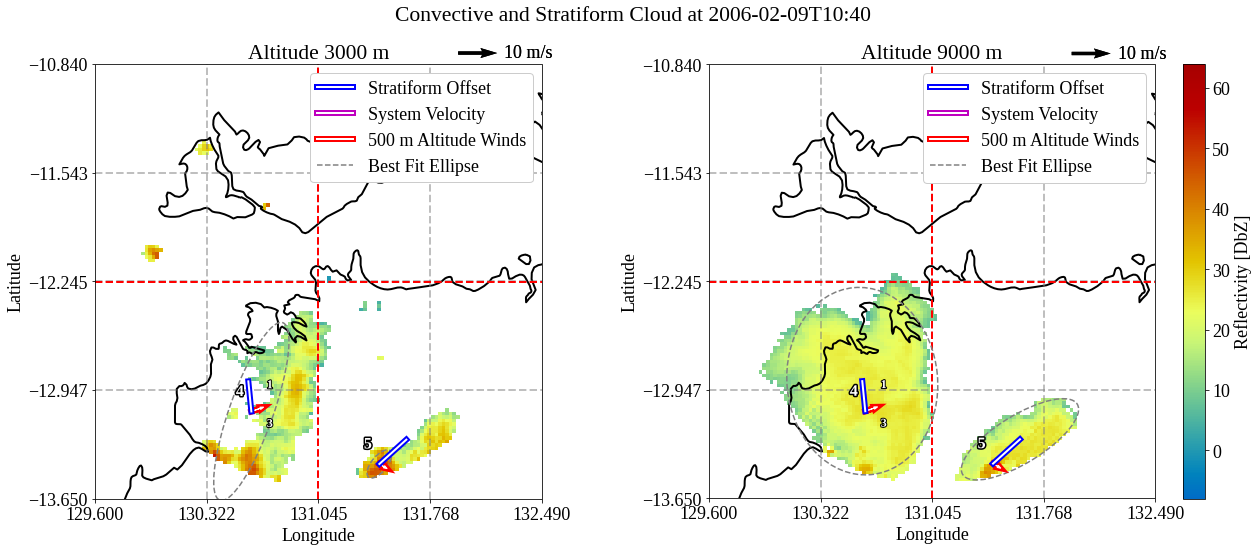

In [51]:
filename = filenames[64]
grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")

params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False,
    'cell_ind': 10, 'winds': False, 'winds_fn': filename, 
    'crosshair': True, 'fontsize': 18, 'colorbar_flag': True,
    'leg_loc': 1, }

tint.visualisation.figures.two_level(
    tracks_obj, grid, params=params, alt=3000)
plt.savefig(
    fig_dir + '/horizontal_cs_{}.png'.format(current_time), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

In [15]:
filename=
grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures'
uid_ind = '1'

params = {
    'uid_ind': uid_ind, 'line_coords': True, 'center_cell': False, 
    'cell_ind': 10, 'winds': True, 'winds_fn': filename,
    'direction': 'perpendicular', 'crosshair': True, 
    'save_dir': fig_dir, 'line_average': True, 'streamplot': True, 
    'relative_winds': True, 'data_fn': 'angles', 
    'load_line_coords_winds': True, 'fontsize': 14}

tint.visualisation.figures.vertical_cross_section(
    tracks_obj, grid, params=params)

NameError: name 'filename' is not defined

> /tmp/ipykernel_24478/3604816378.py(1)<module>()
----> 1 grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])
      2 fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures'
      3 uid_ind = '1'
      4 
      5 params = {

ipdb> q


In [9]:
dates = np.arange(
    np.datetime64('2006-02-09 07:00'), 
    np.datetime64('2006-02-09 07:30'),
    np.timedelta64(10, 'm'))

filenames, start_time, end_time = cf.CPOL_files_from_datetime_list(
    dates, base_dir=base_dir)

Gathering files.


Generating frame 2006-02-09T07:00
Generating figure for 2006-02-09T07:00.
> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/visualisation/figures.py(388)two_level()
    386     import pdb; pdb.set_trace()
    387 
--> 388     ax = fig.add_subplot(1, 2, 2, projection=projection)
    389     horizontal_cross_section(
    390         tracks, grid, params=tmp_params, alt=9000, fig=fig, ax=ax,

ipdb> kwargs
*** NameError: name 'kwargs' is not defined
ipdb> n
> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/visualisation/figures.py(389)two_level()
    387 
    388     ax = fig.add_subplot(1, 2, 2, projection=projection)
--> 389     horizontal_cross_section(
    390         tracks, grid, params=tmp_params, alt=9000, fig=fig, ax=ax,
    391         date_time=date_time)

ipdb> s
> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/visualisation/figures.py(390)two_level()
    388     ax = fig.add_subplot(1, 2, 2, projection=projection)
    389     horizontal_cross_sectio

ipdb> n
> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/visualisation/figures.py(144)horizontal_cross_section()
    142     [
    143         params, alt, fig, ax, date_time, display, alt_ind, cmap,
--> 144         vmin, vmax, projection] = init_cs
    145     display.plot_grid(
    146         tracks.field, level=alt_ind, vmin=vmin, vmax=vmax, cmap=cmap,

ipdb> c


ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._subplots.AxesSubplot'>

> /home/student.unimelb.edu.au/shorte1/Documents/CPOL_analysis/lib/cartopy/_crs.pyx(308)cartopy._crs.CRS._as_mpl_transform()

ipdb> l

ipdb> u
> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/matplotlib/axes/_axes.py(6209)pcolormesh()
   6207         if (not isinstance(t, mtransforms.Transform) and
   6208                 hasattr(t, '_as_mpl_transform')):
-> 6209             t = t._as_mpl_transform(self.axes)
   6210 
   6211         if t and any(t.contains_branch_seperately(self.transData)):

ipdb> self
<AxesSubplot:>
ipdb> self.axes
<AxesSubplot:>
ipdb> u
> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/matplotlib/__init__.py(1361)inner()
   1359     def inner(ax, *args, data=None, **kwargs):
   1360         if data is None:
-> 1361             return func(ax, *map(sanitize_sequence, args), **kwargs)
   1362 
   1363         bound = new_sig.bind(ax, *args, **kwargs)

ipdb> ax
<AxesSubplot:>


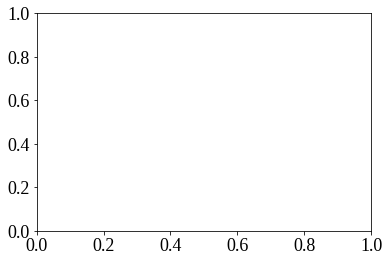

In [9]:
params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False, 
    'cell_ind': 10, 'winds': False, 'winds_fn': filenames, 
    'crosshair': True, 'save_dir': fig_dir, 'alt': 3000, 
    'colorbar_flag': True, 'leg_loc': 1, 'fontsize': 18}

grids = (
    pyart.io.read_grid(fn, include_fields = ['reflectivity'])
    for fn in filenames)

tint.visualisation.animate.animate(
    tracks_obj, grids, params, fig_type='two_level', 
    start_datetime=np.datetime64('2006-02-09 07:00'), 
    end_datetime=np.datetime64('2006-02-09 07:30'))

Generating frame 2006-02-09T05:10:00.000000000


KeyError: 'orientation_alt'

> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/pandas/core/indexes/base.py(3363)get_loc()
   3361                 return self._engine.get_loc(casted_key)
   3362             except KeyError as err:
-> 3363                 raise KeyError(key) from err
   3364 
   3365         if is_scalar(key) and isna(key) and not self.hasnans:

ipdb> q


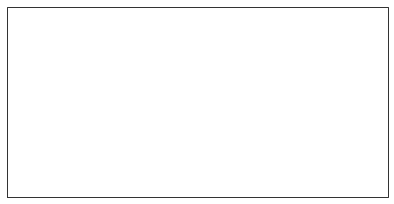

In [10]:
for uid_ind in np.arange(2).astype(str):
    fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures'

    params = {
        'uid_ind': uid_ind, 'line_coords': True, 'center_cell': False, 
        'cell_ind': 7, 'winds': True, 'winds_fn': filenames, 
        'direction': 'perpendicular', 'crosshair': True, 'save_dir': fig_dir,
        'line_average': True, 'streamplot': True, 'relative_winds': True,
        'data_fn': 'angles', 'load_line_coords_winds': False, 
        'save_ds': True}

    grids = (
        pyart.io.read_grid(fn, include_fields = ['reflectivity'])
        for fn in filenames)

    tint.visualisation.animate.animate(tracks_obj, grids, params)

## Assess Tilt

In [17]:
tint.visualisation.figures.concat_angles(
    '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/lin_objects',
    '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/lin_angles.csv',
    12)

,time,uid,streamline_angle,w_max,n_angles,n_obs,max_count,stratiform_offset_angle
0,2006-02-09 08:30:00,0,151.25,2.651685,168.0,820.0,10.0,89.419244
1,2006-02-09 08:40:00,0,91.25,5.463759,162.0,738.0,7.0,86.813102
2,2006-02-09 08:50:00,0,163.75,4.478228,90.0,902.0,15.0,155.353923
3,2006-02-09 09:00:00,0,138.75,2.239941,69.0,369.0,6.0,68.035144
4,2006-02-09 09:10:00,0,166.25,1.536123,30.0,1025.0,6.0,151.175068
...,...,...,...,...,...,...,...,...
9,2006-02-13 10:10:00,11,173.75,2.534968,72.0,779.0,27.0,162.513872
10,2006-02-13 10:20:00,11,173.75,1.882085,42.0,738.0,15.0,167.325305
11,2006-02-13 10:30:00,11,171.25,1.716105,30.0,656.0,6.0,167.377685
12,2006-02-13 10:40:00,11,138.75,5.096160,81.0,451.0,6.0,157.806306


In [22]:
lin_angles = pd.read_csv(fig_dir + '/lin_angles.csv').dropna()
thompson_angles = pd.read_csv(fig_dir + '/thompson_angles.csv').dropna()

In [23]:
# Combined
angle_diff_t, X_t, names = tint.visualisation.figures.get_angle_props(
    thompson_angles, thompson_tracks_obj)
angle_diff_l, X_l, names = tint.visualisation.figures.get_angle_props(
    lin_angles, lin_tracks_obj)
angle_diff = np.concatenate([angle_diff_t, angle_diff_l])
X = np.concatenate([X_t, X_l])
sl_angles_t = thompson_angles['streamline_angle'].values
so_angles_t = thompson_angles['stratiform_offset_angle'].values
sl_angles_l = lin_angles['streamline_angle'].values
so_angles_l = lin_angles['stratiform_offset_angle'].values
sl_angles = np.concatenate([sl_angles_t, sl_angles_l])
so_angles = np.concatenate([so_angles_t, so_angles_l])

In [15]:
# Single
angle_diff, X, names = tint.visualisation.figures.get_angle_props(
    thompson_angles, thompson_tracks_obj)
# angle_diff, X, names = tint.visualisation.figures.get_angle_props(
#     lin_angles, lin_tracks_obj)

In [24]:
from sklearn import tree
clf = tree.DecisionTreeRegressor(min_samples_split=.25)
clf.fit(X, angle_diff)

DecisionTreeRegressor(min_samples_split=0.25)

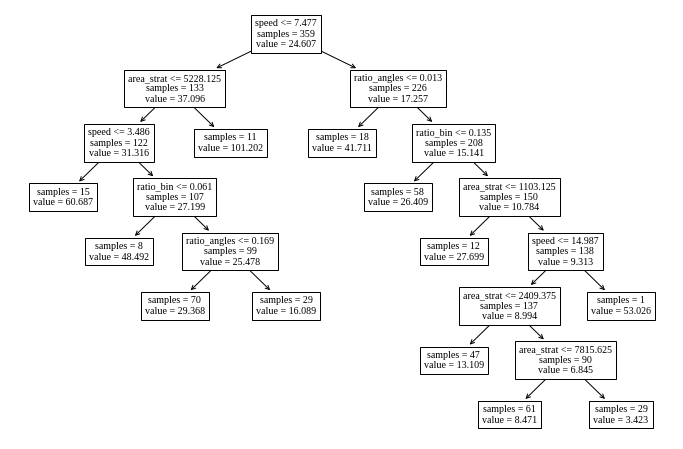

In [25]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
tree.plot_tree(
    clf, max_depth=10, ax=ax, feature_names=names, fontsize=10, 
    label='all', impurity=False)
fig.savefig(fig_dir + 'tree_combined.pdf', facecolor='w', format='pdf')

In [26]:
[
        w_max, ratio_angles, ratio_bin, ratio_border_conv, 
        ratio_border_strat, area_conv, area_strat, eccentricity, 
        speed] = [X[:,i] for i in range(X.shape[1])]

In [31]:
# Combined criteria
cond1 = (speed <= 7.477) & (area_strat <= 5228.125) & (speed > 3.486) & (ratio_bin > 0.061) & (ratio_angles > 0.169)
cond2 = (speed > 7.477) & (ratio_angles > 0.013) & (ratio_bin > 0.135) & (area_strat > 1103)
cond = cond1 | cond2

In [27]:
# Combined criteria
cond2 = ratio_angles > 0.1
cond3 = ratio_bin > 0.1
cond4 = area_conv > 2000
cond4 = area_strat > 2000
cond = cond2 & cond3 & cond4

In [53]:
# Combined criteria
cond1 = speed > 7.5
cond2 = ratio_angles > 0.013
cond3 = ratio_bin > 0.135
cond5 = np.array(area_strat) > 2409
cond6 = speed <= 14.987
cond7 = np.array(ratio_border_conv) <= 0.037
cond8 = np.array(area_conv) > 325.0
# cond = cond1 & cond2 & cond3 & cond5 # & cond7
cond = cond1 & cond2 & cond3 & cond5 & cond6

In [569]:
# Thompson split criteria
cond1 = speed > 7.568
cond2 = ratio_angles > 0.013
cond3 = ratio_bin > 0.082
cond4 = speed <= 14.987
cond5 = np.array(area_strat) > 1650
cond6 = np.array(ratio_border_conv) <= 0.037
cond7 = np.array(area_conv) > 325.0
cond = cond1 & cond2 & cond3 & cond4 # & cond5 & cond7

In [524]:
cond1a = (ratio_angles <= 0.021)
cond1b = (ratio_angles > 0.021) & (ratio_bin <= 0.213)
cond1 = (speed <= 7.568) & (ratio_angles > 0.001) & (ratio_bin > 0.055) & (speed > 4.93) & (cond1a | cond1b)
cond2a = (speed <= 10.09)
cond2b = (speed > 10.09) & (ratio_bin > 0.137)
cond2 = (speed > 7.568) & (ratio_angles > 0.013) & (ratio_bin > 0.082) & (speed <= 14.987) & (cond2a | cond2b)
cond = cond1 | cond2

In [374]:
# Lin split criteria
cond1 = speed > 0
cond2 = ratio_angles > 0.011
cond3 = ratio_bin > 0.127
cond4 = w_max > 1
cond = cond1 & cond2 & cond3 & cond4

In [386]:
# Lin split criteria
cond1 = (ratio_bin > 0.221) & (speed > 6.943) & (eccentricity > 0.679)
cond2 = (
    (ratio_bin <= 0.221) & (ratio_angles > 0.011) & (w_max > 2.243)
    & (
        ((ratio_bin > 0.116) & (speed > 3.676)) 
        | ((ratio_bin <= 0.113) & (ratio_bin > 0.049))))
cond = cond1 | cond2

In [534]:
len(cond[cond==True])

51

(0.12276354191822786, 0.31859736964950425)

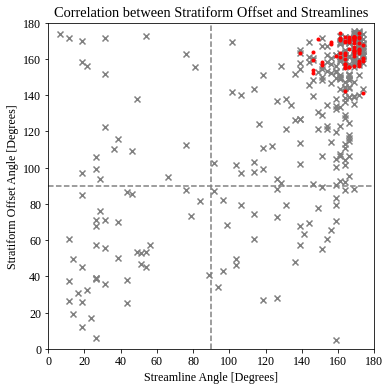

In [30]:
tint.visualisation.figures.angle_correlation(
    sl_angles, so_angles, cond, fig_dir + 'combined_angle_correlation_crude.png')
pearsonr(sl_angles[cond], so_angles[cond])

In [29]:
from scipy.stats.stats import pearsonr 


In [15]:
np.rad2deg(np.arctan2(5.5,-30))

169.6111421845304

In [18]:
from skimage.transform import radon
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb

In [25]:
test = (image == 0).astype(int)

In [29]:
filename = filenames[36]
grid = pyart.io.read_grid(filename, include_fields = ['reflectivity'])
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures'

params = {
    'uid_ind': '1', 'line_coords': False, 'center_cell': False, 
    'cell_ind': 4, 'winds': False, 'winds_fn': filename,
    'crosshair': True, 'save_dir': None, 'legend': False}

tint.visualisation.figures.object(tracks_obj, grid, params=params)

IndexError: list index out of range

> /tmp/ipykernel_21199/4030395361.py(1)<module>()
----> 1 filename = filenames[36]
      2 grid = pyart.io.read_grid(filename, include_fields = ['reflectivity'])
      3 fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures'
      4 
      5 params = {

ipdb> q


Interpolating onto line coordinates.
Calculating horizontal winds in new basis.


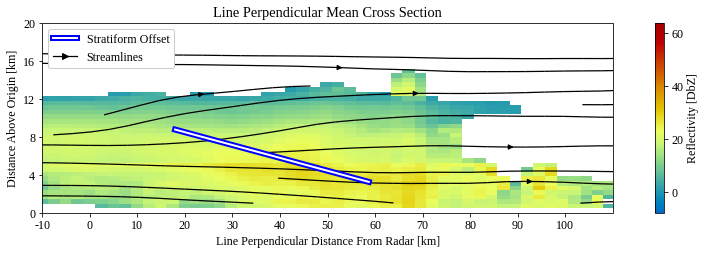

In [38]:
params = {
    'uid_ind': '1', 'line_coords': True, 'center_cell': False,
    'cell_ind': 4, 'direction': 'perpendicular', 'winds': True, 
    'winds_fn': filename, 'line_average': True, 'streamplot': True}

tint.visualisation.figures.vertical_cross_section(
    tracks_obj, grid, params=params)

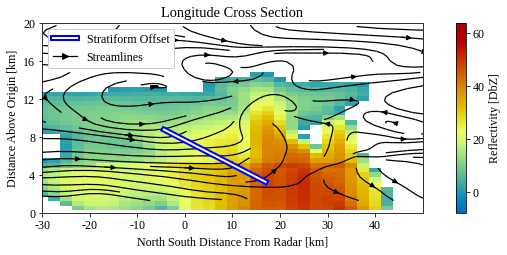

In [10]:
params = {
    'uid_ind': '2', 'line_coords': False, 'center_cell': False,
    'cell_ind': 0, 'direction': 'lon', 'winds': True, 
    'winds_fn': filename, 'line_average': False, 'streamplot': True}

tint.visualisation.figures.vertical_cross_section(
    tracks_obj, grid, params=params)

# Create Categories

In [7]:
categories = helpers.create_categories(tracks_obj)

In [8]:
subset_logic = (categories['not_border'] & categories['not_border_0'] 
                & ~categories['large_area'] & ~categories['small_area'] 
                & categories['linear'] & ~categories['stationary'] 
                & categories['sig_vel_mag'])
sub_cat = categories[subset_logic]

In [9]:
uids = list(set([tracks_obj.system_tracks.index[i][2] for i in range(len(tracks_obj.system_tracks))]))

ratio = []
tot_rain = []

for u in uids:
    hours = len(tracks_obj.system_tracks.xs(u, level='uid'))*1/6
    r = categories.xs(u, level='uid')['par_align'].sum()/len(tracks_obj.system_tracks.xs(u, level='uid'))
    ratio.append(r)
    tot_rain.append(tracks_obj.system_tracks.xs(u, level='uid')['tot_rain'][-1])
# tracks_obj.system_tracks.xs('0', level='uid')['vel_dir']

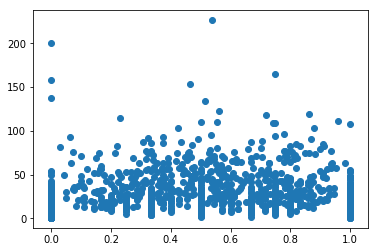

In [10]:
tot_rain = np.array(tot_rain)
tot_rain[tot_rain>500]=np.nan
plt.scatter(ratio, tot_rain)

In [73]:
sub_cat['par_align'].groupby(level='uid').sum().sort_values(ascending=False)[:20]

Series([], Name: par_align, dtype: bool)

# Calculate Some Statistics

## PS, TS, LS Breakdown

In [34]:
subset_logic = sig_area & not_border & not_border_0 & sig_vel_mag & sig_tilt_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
# sub_tracks = tracks_obj.system_tracks

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
max_MCS = max(MCS_lengths)

# Create 3 lists with lengths the lifetime of longest object.
[TS, LS, PS, totals] = [np.zeros(100) for i in range(4)]

for i in sub_uids:
    
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    tilts = obj['sys_rel_tilt_dir']
    
    # Break down sig_tilt categories
    forward_tilt = ((-45 <= tilts) & (tilts <= 45)) 
    backward_tilt = ((-135 >= tilts) | (tilts >= 135)) 

    fwd_inds = scan_label[np.argwhere(forward_tilt).flatten().tolist()].tolist()
    bwd_inds = scan_label[np.argwhere(backward_tilt).flatten().tolist()].tolist()
    pll_inds = scan_label[np.argwhere(~backward_tilt & ~forward_tilt).flatten().tolist()].tolist()
    totals_inds = scan_label.tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        TS[bwd_inds] += 1
        LS[fwd_inds] += 1
        PS[pll_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

## System Size

In [7]:
# subset_logic = ~small_area
# sub_tracks = tracks_obj.system_tracks[subset_logic]
sub_tracks = tracks_obj.system_tracks

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

# MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
# max_MCS = max(MCS_lengths)

In [14]:
# Create 3 lists with lengths the lifetime of longest object.
[large, small, medium, nb, totals] = [np.zeros(100) for i in range(5)]

from tqdm import tqdm

for i in tqdm(sub_uids, file=sys.stdout, position=0, leave=True):
    
#     import pdb
#     pdb.set_trace()
    
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    cat = categories.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    
    # Define classifications
    large_area = cat['large_area'].values
    small_area = cat['small_area'].values
    medium_area = ~large_area & ~small_area
    not_border = cat['not_border'].values | cat['not_border_0'].values
    
    large_inds = scan_label[large_area]
    medium_inds = scan_label[medium_area]
    small_inds = scan_label[small_area]
    not_border_inds = scan_label[not_border]
    totals_inds = scan_label.tolist()
    
    # Break down sig_tilt categories
#     forward_tilt = ((-45 <= tilts) & (tilts <= 45)) 
#     backward_tilt = ((-135 >= tilts) | (tilts >= 135)) 

#     fwd_inds = scan_label[np.argwhere(forward_tilt).flatten().tolist()].tolist()
#     bwd_inds = scan_label[np.argwhere(backward_tilt).flatten().tolist()].tolist()
#     pll_inds = scan_label[np.argwhere(~backward_tilt & ~forward_tilt).flatten().tolist()].tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        large[large_inds] += 1
        small[small_inds] += 1
        medium[medium_inds] += 1
        nb[not_border_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

100%|██████████| 25948/25948 [02:18<00:00, 186.83it/s]


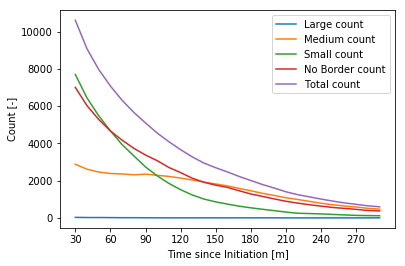

In [17]:
plt.plot(np.arange(30,300,10), large[3:30], label='Large count')
plt.plot(np.arange(30,300,10), medium[3:30], label='Medium count')
plt.plot(np.arange(30,300,10), small[3:30], label='Small count')
plt.plot(np.arange(30,300,10), nb[3:30], label='No Border count')
plt.plot(np.arange(30,300,10), totals[3:30], label='Total count')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

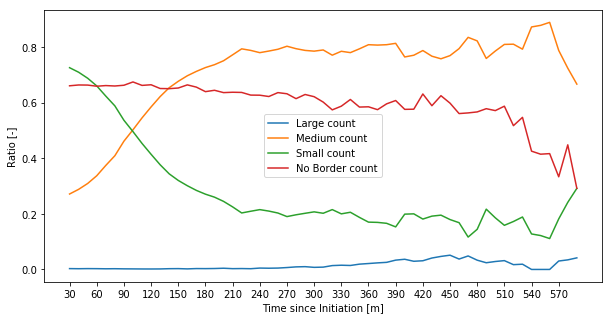

In [22]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(30,600,10), (large/totals)[3:60], label='Large count')
plt.plot(np.arange(30,600,10), (medium/totals)[3:60], label='Medium count')
plt.plot(np.arange(30,600,10), (small/totals)[3:60], label='Small count')
plt.plot(np.arange(30,600,10), (nb/totals)[3:60], label='No Border count')
plt.xticks(np.arange(30,600,30))
plt.ylabel('Ratio [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
# Note that we don't really know the start times of the systems!
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_ratios.png')

## Training Lines

In [12]:
subset_logic = (categories['not_border'] & categories['not_border_0']
                & ~categories['large_area'] & ~categories['small_area'] 
                & categories['linear'] & ~categories['stationary']
                & categories['sig_vel_mag'])
sub_tracks = tracks_obj.system_tracks[subset_logic]
sub_cat = categories[subset_logic]
# sub_tracks = tracks_obj.system_tracks
# sub_cat = categories

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2])
                            for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

# MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
# max_MCS = max(MCS_lengths)

In [13]:
# Create 3 lists with lengths the lifetime of longest object.
[par, perp, totals] = [np.zeros(100) for i in range(3)]

from tqdm import tqdm

for i in tqdm(sub_uids, file=sys.stdout, position=0, leave=True):
       
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    cat = sub_cat.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    
    # Define classifications
    perp_align = cat['perp_align'].values
    par_align = cat['par_align'].values
        
    par_inds = scan_label[par_align]
    perp_inds = scan_label[perp_align]
    totals_inds = scan_label.tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        par[par_inds] += 1
        perp[perp_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

100%|██████████| 91/91 [00:00<00:00, 170.20it/s]


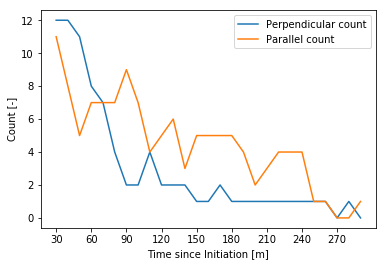

In [14]:
plt.plot(np.arange(30,300,10), perp[3:30], label='Perpendicular count')
plt.plot(np.arange(30,300,10), par[3:30], label='Parallel count')
# plt.plot(np.arange(30,300,10), totals[3:30], label='Total count')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

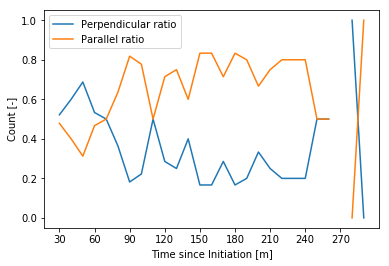

In [15]:
plt.plot(np.arange(30,300,10), (perp/totals)[3:30], label='Perpendicular ratio')
plt.plot(np.arange(30,300,10), (par/totals)[3:30], label='Parallel ratio')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

## Updraft Tilt versus Stratiform Tilt

In [29]:
def calc_mean_max_updrafts(system_tracks, min_height_ind = 20):
    ud = system_tracks['updrafts']
    ud_tilt = []
    tallest_ud = []
    mean_ud = []
    no_tilt=0
    for i in range(len(ud)):
        ud_i = ud.iloc[i]
        ud_tilt_i = []
        for j in range(len(ud_i)):
            if ud_i[j][-1][0] >= min_height_ind:
                ud_tilt_i_j = (ud_i[j][-1]-ud_i[j][0])*(.5, 2.5, 2.5)
                if np.all(ud_tilt_i_j[1:3] == [0,0]):
                    # Count updrafts with no tilt seperately
                    no_tilt+=1
                else:
                    ud_tilt_i.append(ud_tilt_i_j)
       
        if ud_tilt_i != []:
            ud_tilt.append(ud_tilt_i)
            mean_ud.append(np.nanmean(np.array(ud_tilt_i), axis=0))
        else:
            ud_tilt.append(np.ones(3)*np.nan)
            mean_ud.append(np.ones(3)*np.nan)
        try:
            tallest_ind = np.argmax(np.array(ud_tilt_i)[:,0])
            tallest_ud.append(np.array(ud_tilt_i)[tallest_ind,:])
        except:
            tallest_ud.append(np.ones(3)*np.nan)
        
    return ud_tilt, mean_ud, tallest_ud

### Tallest Updraft

In [33]:
subset_logic = sig_area & not_border & sig_tilt_mag & not_border_0 & sig_vel_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
ud_tilt, mean_ud, tallest_ud = calc_mean_max_updrafts(sub_tracks)

num = np.array(tallest_ud)
den = np.tile(np.array(tallest_ud)[:,0], (3,1)).transpose()
ud_norm = (num/den)[:,1:]
ud_mag = np.sqrt(ud_norm[:,0] ** 2 + ud_norm[:,1] ** 2)
ud_dir = np.arctan2(ud_norm[:,0], ud_norm[:,1])
ud_dir = np.rad2deg(ud_dir)

vel_dir = sub_tracks['vel_dir'].values
tilt_dir = sub_tracks['tilt_dir'].values

sys_rel_tilt_dir = np.mod(tilt_dir - vel_dir, 360)
sys_rel_tilt_dir = np.round(sys_rel_tilt_dir, 3)

sys_rel_ud_tilt_dir = np.mod(ud_dir - vel_dir, 360)
sys_rel_ud_tilt_dir = np.round(sys_rel_ud_tilt_dir, 3)

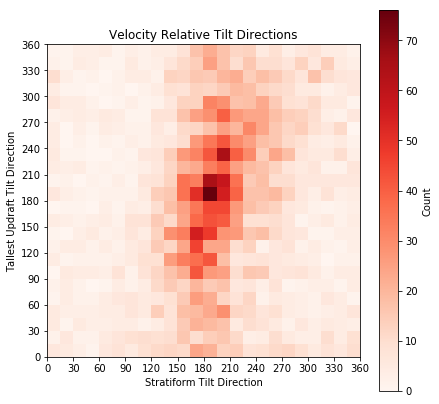

In [35]:
vel_dir = sub_tracks['vel_dir'].values
vel_mag = np.sqrt(sub_tracks['u_shift']**2 + sub_tracks['v_shift']**2).values
tilt_dir = sub_tracks['tilt_dir'].values
bins = np.arange(0,360+15,15)
ticks = np.arange(0,360+30,30)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)
h = ax.hist2d(sys_rel_tilt_dir, sys_rel_ud_tilt_dir, bins=bins, range=[[0, 360], [0, 360]], cmap='Reds')
# ax.scatter(tilt_dir, ud_dir, s=0.75)
plt.xlabel('Stratiform Tilt Direction')
plt.ylabel('Tallest Updraft Tilt Direction')
plt.title('Velocity Relative Tilt Directions')
plt.xlim([0, 360])
plt.ylim([0, 360])
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_aspect('equal')
cb = plt.colorbar(h[3], ax=ax)
cb.set_label('Count')

### Mean Updraft

In [36]:
subset_logic = sig_area & not_border & sig_tilt_mag & not_border_0 & sig_vel_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
ud_tilt, mean_ud, tallest_ud = calc_mean_max_updrafts(sub_tracks)

num = np.array(mean_ud)
den = np.tile(np.array(mean_ud)[:,0], (3,1)).transpose()
ud_norm = (num/den)[:,1:]
ud_mag = np.sqrt(ud_norm[:,0] ** 2 + ud_norm[:,1] ** 2)
ud_dir = np.arctan2(ud_norm[:,0], ud_norm[:,1])
ud_dir = np.rad2deg(ud_dir)

vel_dir = sub_tracks['vel_dir'].values
tilt_dir = sub_tracks['tilt_dir'].values

sys_rel_tilt_dir = np.mod(tilt_dir - vel_dir, 360)
sys_rel_tilt_dir = np.round(sys_rel_tilt_dir, 3)

sys_rel_ud_tilt_dir = np.mod(ud_dir - vel_dir, 360)
sys_rel_ud_tilt_dir = np.round(sys_rel_ud_tilt_dir, 3)

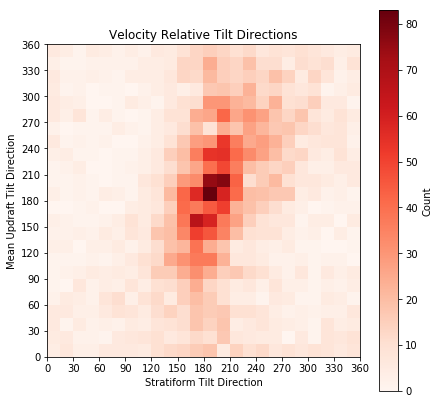

In [38]:
vel_dir = sub_tracks['vel_dir'].values
vel_mag = np.sqrt(sub_tracks['u_shift']**2 + sub_tracks['v_shift']**2).values
tilt_dir = sub_tracks['tilt_dir'].values
bins = np.arange(0,360+15,15)
ticks = np.arange(0,360+30,30)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)
h = ax.hist2d(sys_rel_tilt_dir, sys_rel_ud_tilt_dir, bins=bins, range=[[0, 360], [0, 360]], cmap='Reds')
# ax.scatter(tilt_dir, ud_dir, s=0.75)
plt.xlabel('Stratiform Tilt Direction')
plt.ylabel('Mean Updraft Tilt Direction')
plt.title('Velocity Relative Tilt Directions')
plt.xlim([0, 360])
plt.ylim([0, 360])
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_aspect('equal')
cb = plt.colorbar(h[3], ax=ax)
cb.set_label('Count')